In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings;
warnings.filterwarnings('ignore')

C:\Users\hungu\anaconda.x\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
train = pd.read_csv('train_5UKooLv.csv')
test = pd.read_csv('test_J1hm2KQ.csv')
submission = pd.read_csv('sample_submission_r7hs8Tz.csv')

In [3]:
train.head()

,CustomerID,InvoiceNo,Quantity,InvoiceDate,UnitPrice,Country,StockCode
0,27270,27270,7,01/12/10 8:26,2.55,PX,85123AY
1,27270,27270,7,01/12/10 8:26,3.39,PX,71053R
2,27270,27270,9,01/12/10 8:26,2.75,PX,84406BH
3,27270,27270,7,01/12/10 8:26,3.39,PX,84029GV
4,27270,27270,7,01/12/10 8:26,3.39,PX,84029EX


In [4]:
test.head()

,Country,CustomerID,InvoiceDate,InvoiceNo,Quantity,StockCode,UnitPrice
0,PX,127269,01/12/10 8:28,127269,7,22633V,1.85
1,PX,227268,01/12/10 8:34,227268,38,84879M,1.69
2,PX,227268,01/12/10 8:34,227268,7,22748P,2.10
3,PX,227268,01/12/10 8:34,227268,9,22749K,3.75
4,PX,227268,01/12/10 8:34,227268,2,22622G,9.95


In [5]:
train.shape, test.shape

((330575, 7), (103097, 7))

In [6]:
test.isnull().sum()

Country        0
CustomerID     0
InvoiceDate    0
InvoiceNo      0
Quantity       0
StockCode      0
UnitPrice      0
dtype: int64

In [7]:
train.isnull().sum()

CustomerID     0
InvoiceNo      0
Quantity       0
InvoiceDate    0
UnitPrice      0
Country        0
StockCode      0
dtype: int64

In [8]:
train.dtypes

CustomerID       int64
InvoiceNo        int64
Quantity         int64
InvoiceDate     object
UnitPrice      float64
Country         object
StockCode       object
dtype: object

In [9]:
data = train.append(test)

In [10]:
data['StockCode'] = data['StockCode'].astype('str')

In [11]:
customers = data['CustomerID'].unique().tolist()
len(customers)

1600

In [12]:
submission.shape

(628, 2)

In [13]:
purchases_data = []

for i in tqdm(customers):
    t = data[data['CustomerID']== i]['StockCode'].tolist()
    purchases_data.append(t)

100%|█████████████████████████████████████████████████████████████████████████████| 1600/1600 [00:02<00:00, 758.25it/s]


In [15]:
model = Word2Vec(window=10, sg=1, hs=0,
                 negative=10, alpha=0.03, min_alpha=0.0007, seed=14)

model.build_vocab(purchases_data, progress_per=200)

model.train(purchases_data, total_examples=model.corpus_count,
            epochs=10, report_delay=1)

(4307991, 4336720)

In [16]:
model.corpus_count

1600

In [17]:
model.init_sims(replace=True)

In [18]:
print(model)

Word2Vec(vocab=3407, size=100, alpha=0.03)


In [19]:
X = model[model.wv.vocab]
X.shape

(3407, 100)

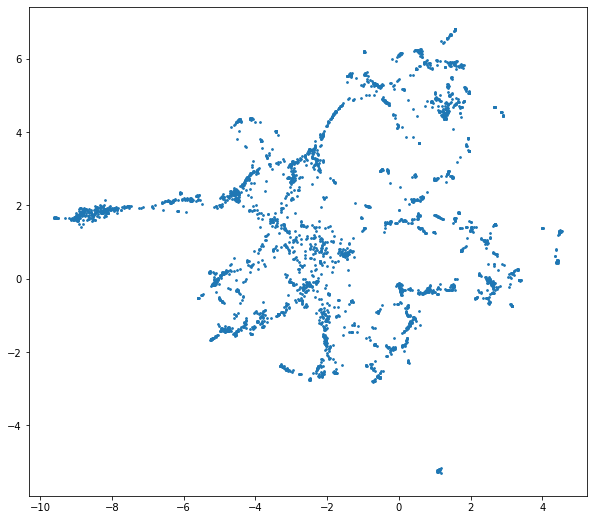

In [20]:
import umap

cluster_embedding = umap.UMAP(n_neighbors=20, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

In [21]:
products = test[['CustomerID','StockCode']]

products.drop_duplicates(inplace=True, keep='last')

In [22]:
product_info = products.groupby('CustomerID')['StockCode'].apply(list).to_dict()

In [23]:
len(product_info)

628

In [24]:
def get_similar_products(product, num = 10):
    ms = model.similar_by_vector(product, topn= num+1)[1:]
    temp = []
    for j in ms:
        pair = j[0]
        temp.append(pair)
    return temp

In [25]:
get_similar_products(model['22418R'])

['22419N',
 '22421F',
 '22420M',
 '22437B',
 '22422Q',
 '22492E',
 '22439F',
 '22489J',
 '22537N',
 '22446X']

In [26]:
customers_sample = submission['CustomerID']
list_submission = []
list_sm_prod = []
for i in range(len(customers_sample)):
    list_sm_prod = []
    product_stock = product_info[customers_sample.values[i]]
    for j in range(len(product_stock)):
        try:
            list_sm_prod.append(get_similar_products(model[product_info[customers_sample.values[i]][j]]))
        except KeyError:
            c = 0
    list_sm_prod = sum(list_sm_prod, [])
    list_submission.append(list_sm_prod)

In [27]:
submission['Items'] = list_submission
submission.to_csv('sample.csv', header=True, index=False)

In [28]:
submission.head()

,CustomerID,Items
0,258048,"[22209G, 22210R, 22211Y, 22204L, 22214T, 22196..."
1,520875,"[22962X, 22969Z, 22960K, 22961C, 22993E, 22978..."
2,542745,"[22459S, 22456H, 22451T, 22477A, 22457C, 22471..."
3,477216,"[23146P, 23148U, 23136V, 23140N, 23139D, 23152..."
4,251937,"[84406BH, 84840M, 84849AN, 84755J, 84836J, 843..."


In [29]:
submission.to_csv('submission.csv', index=False)